# Synthetic Line

One of the easiest ways to build a model predicting events is to use some combination of the markets, or sportsbooks. In data science, this is akin to creating a "stacked" model where the outputs of multiple models are combined in a linear or non-linear model to come up with an optimized scheme. Linear models can be thought of as simply weighting each market. For example, using historical data, we may find that Draftkings head-to-head round matchup odds are the sharpest followed by Pinnacle, and then Bookmaker. A model can provide the optimal weights that each sportsbook would get. Using this example, it may be 50% Draftkings, 30% Pinnacle, and 20% Bookmaker.

The goal of this analysis is to come up with an optimized synthetic line for PGA Tour head-to-head **round** matchups.

## Package Import

In [2]:
import pandas as pd
import numpy as np
from google.cloud import bigquery

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

pd.set_option('max_columns', 100)

client = bigquery.Client()

## Data Import

Using DataGolf's API, I have historical round matchups across various sportsbooks. In addition to the historical data, I've created a BigQuery table that includes the sportsbooks that DataGolf currently supports. After all, we need to be able to get new data when making future predictions with a model.

### Active Sportsbooks

In [3]:
sportsbook_query = client.query("SELECT * FROM `golf-predict.entities.sportsbooks` WHERE active = 1")

sportsbooks = sportsbook_query.result().to_dataframe()

In [4]:
(sportsbooks
 .query("odds_type == 'matchups'")
 .sort_values(['start_date'])
 .reset_index(drop=True)
)

,sportsbook,odds_type,start_date,end_date,active
0,bet365,matchups,2019-01-20,None,1
1,bovada,matchups,2019-01-20,None,1
2,pinnacle,matchups,2019-03-26,None,1
3,draftkings,matchups,2019-05-29,None,1
4,betcris,matchups,2019-10-09,None,1
5,betonline,matchups,2020-02-11,None,1
6,fanduel,matchups,2020-10-06,None,1
7,betmgm,matchups,2021-01-15,None,1
8,pointsbet,matchups,2021-05-05,None,1
9,circa,matchups,2022-01-04,None,1


We have 11 active sportsbooks that have historical matchup data. Some (Circa, Unibet) are more recent than others, but we will explore using only 2022 data to predict the matchups that have occurred throughout 2023 thus far.

In [5]:
active_books = sportsbooks.query("odds_type == 'matchups'")['sportsbook']
active_books

0         bet365
1        betcris
2         betmgm
3      betonline
4         bovada
5          circa
6     draftkings
7        fanduel
8       pinnacle
9      pointsbet
10        unibet
Name: sportsbook, dtype: object

### Historical Matchups

In [6]:
matchups_query = client.query("SELECT * FROM `golf-predict.historical_betting_odds.matchups`")

matchups = matchups_query.result().to_dataframe()

In [7]:
matchups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311682 entries, 0 to 311681
Data columns (total 28 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   bet_type         311578 non-null  object             
 1   close_time       311578 non-null  datetime64[ns, UTC]
 2   open_time        311578 non-null  datetime64[ns, UTC]
 3   p1_close         311578 non-null  float64            
 4   p1_dg_id         311578 non-null  float64            
 5   p1_open          311578 non-null  float64            
 6   p1_outcome       311578 non-null  float64            
 7   p1_outcome_text  311578 non-null  object             
 8   p1_player_name   311578 non-null  object             
 9   p2_close         311578 non-null  float64            
 10  p2_dg_id         311578 non-null  float64            
 11  p2_open          311578 non-null  float64            
 12  p2_outcome       311578 non-null  float64            
 13 

I would typically do a lot of filtering and such within the SQL query, but simply importing all data to do a lot more work with Python

In [8]:
matchups.columns

Index(['bet_type', 'close_time', 'open_time', 'p1_close', 'p1_dg_id',
       'p1_open', 'p1_outcome', 'p1_outcome_text', 'p1_player_name',
       'p2_close', 'p2_dg_id', 'p2_open', 'p2_outcome', 'p2_outcome_text',
       'p2_player_name', 'p3_close', 'p3_dg_id', 'p3_open', 'p3_outcome',
       'p3_outcome_text', 'p3_player_name', 'tie_rule', 'book',
       'event_completed', 'event_name', 'season', 'year', 'event_id'],
      dtype='object')

In [9]:
keep_cols = [
    'bet_type', 'close_time', 'open_time', 
    'p1_close', 'p1_dg_id', 'p1_open', 'p1_outcome', 'p1_outcome_text', 'p1_player_name',
    'p2_close', 'p2_dg_id', 'p2_open', 'p2_outcome', 'p2_outcome_text', 'p2_player_name', 
    'tie_rule', 'book', 'event_completed', 'event_name', 'season', 'year', 'event_id'
]

In [10]:
matchups.head()

,bet_type,close_time,open_time,p1_close,p1_dg_id,p1_open,p1_outcome,p1_outcome_text,p1_player_name,p2_close,p2_dg_id,p2_open,p2_outcome,p2_outcome_text,p2_player_name,p3_close,p3_dg_id,p3_open,p3_outcome,p3_outcome_text,p3_player_name,tie_rule,book,event_completed,event_name,season,year,event_id
0,None,NaT,NaT,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,None,None,None,5dimes,2023-06-04,the Memorial Tournament presented by Workday,2023,2023,23
1,None,NaT,NaT,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,None,None,None,sportsbook,2023-06-04,the Memorial Tournament presented by Workday,2023,2023,23
2,None,NaT,NaT,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,None,None,None,williamhill,2023-06-04,the Memorial Tournament presented by Workday,2023,2023,23
3,R1 Match-Up,2023-06-01 08:31:00+00:00,2023-05-30 23:32:00+00:00,2.10,6430.0,1.95,1.0,win,"Scott, Adam",1.77,26651.0,1.87,0.0,loss,"Young, Cameron",NaN,NaN,NaN,NaN,None,None,Bets are void in event of tie,bet365,2023-06-04,the Memorial Tournament presented by Workday,2023,2023,23
4,R1 Match-Up,2023-06-01 04:33:00+00:00,2023-05-30 23:32:00+00:00,1.95,17786.0,1.95,1.0,win,"Davis, Cameron",1.87,21891.0,1.87,0.0,loss,"Kitayama, Kurt",NaN,NaN,NaN,NaN,None,None,Bets are void in event of tie,bet365,2023-06-04,the Memorial Tournament presented by Workday,2023,2023,23


In [11]:
matchups = matchups[keep_cols].copy()

Some factors we want to consider as we filter our base population for modeling. 
1. Ties are void (ie two-way markets)
2. Round matchups only
3. From an active sportsbook

In [12]:
print(matchups.tie_rule.unique())
print(matchups.bet_type.unique())

[None 'Bets are void in event of tie' 'Separate bet offered for tie'
 'Ties settled by dead-heat rules']
[None 'R1 Match-Up' 'R2 Match-Up' 'R3 Match-Up' 'R4 Match-Up'
 '72-hole Match' 'R2 3-Ball' 'R1 3-Ball' 'R3 3-Ball' 'R4 3-Ball']


In [13]:
# creating round list for filtering
round_list = list(map(lambda x: 'R' + x, list(map(str, range(1,5)))))

# filter criteria
tie_rule_filt = matchups.tie_rule == 'Bets are void in event of tie'
sportsbk_filt = matchups.book.str.contains('|'.join(active_books))
bet_type_filt = matchups.bet_type.str.contains('|'.join(round_list))
year_filt = [2022, 2023]

df = matchups.loc[tie_rule_filt & sportsbk_filt & bet_type_filt & matchups.year.isin(year_filt)].reset_index(drop=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69661 entries, 0 to 69660
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   bet_type         69661 non-null  object             
 1   close_time       69661 non-null  datetime64[ns, UTC]
 2   open_time        69661 non-null  datetime64[ns, UTC]
 3   p1_close         69661 non-null  float64            
 4   p1_dg_id         69661 non-null  float64            
 5   p1_open          69661 non-null  float64            
 6   p1_outcome       69661 non-null  float64            
 7   p1_outcome_text  69661 non-null  object             
 8   p1_player_name   69661 non-null  object             
 9   p2_close         69661 non-null  float64            
 10  p2_dg_id         69661 non-null  float64            
 11  p2_open          69661 non-null  float64            
 12  p2_outcome       69661 non-null  float64            
 13  p2_outcome_text 

In [15]:
# change a few types
df.p1_dg_id = df.p1_dg_id.astype(int)
df.p2_dg_id = df.p2_dg_id.astype(int)

In [16]:
df[['book','year']].value_counts()

book        year
pinnacle    2022    10436
betcris     2022     7756
bovada      2022     6563
betonline   2022     6201
unibet      2022     5667
draftkings  2022     4202
bet365      2022     3990
bovada      2023     3507
pinnacle    2023     3334
betcris     2023     2923
betonline   2023     2586
unibet      2023     2287
betmgm      2022     2247
circa       2022     1881
draftkings  2023     1694
circa       2023     1628
bet365      2023     1452
betmgm      2023      973
fanduel     2023      203
            2022      131
dtype: int64

In [17]:
# create a unique ID
df['matchup_id'] = (
    df[['year','season','event_id','p1_dg_id','p2_dg_id','bet_type']]
    .apply(lambda x: x.astype(str))
    .apply(lambda x: '-'.join(x), axis=1)
)

#df.loc[df.duplicated(keep=False)]

In [18]:
dup_matchups = df.loc[df[['matchup_id','book']].duplicated(keep=False)]

In [19]:
dup_matchups.book.value_counts()

bovada      164
pinnacle      2
Name: book, dtype: int64

In [20]:
remove_book = ['bovada','pointsbet','unibet', # removing these books based on industry knowledge
               'bet365','circa','fanduel'] # these 3 have little common matchups

In [21]:
df = df[~df.book.isin(remove_book) & ~df.duplicated(subset=['book','matchup_id'])].reset_index(drop=True).copy()

In [22]:
df.book.unique()

array(['betcris', 'betmgm', 'betonline', 'draftkings', 'pinnacle'],
      dtype=object)

In [23]:
(pd.crosstab(df['matchup_id'], df['book'])
 .reset_index()
 .query("betmgm == 1")
 .drop(['matchup_id'], axis=1)
 .apply(lambda x: sum(x))
)

book
betcris        977
betmgm        3220
betonline      979
draftkings    2006
pinnacle      1507
dtype: int64

# TO DO

Create a function that will develop the optimal synthetic lines for 2022, evaluate on 2023 matchups. Do this for Illinois books (BetMGM, Draftkings).

In [24]:
df['p1_prob'] = 1/df.p1_close
df['p2_prob'] = 1/df.p2_close

df['p1_prob_novig'] = df['p1_prob'] - ((df['p1_prob'] + df['p2_prob']) - 1)/2
df['p2_prob_novig'] = df['p2_prob'] - ((df['p1_prob'] + df['p2_prob']) - 1)/2

In [25]:
df.head()

,bet_type,close_time,open_time,p1_close,p1_dg_id,p1_open,p1_outcome,p1_outcome_text,p1_player_name,p2_close,p2_dg_id,p2_open,p2_outcome,p2_outcome_text,p2_player_name,tie_rule,book,event_completed,event_name,season,year,event_id,matchup_id,p1_prob,p2_prob,p1_prob_novig,p2_prob_novig
0,R1 Match-Up,2023-06-01 08:31:00+00:00,2023-05-30 20:31:00+00:00,1.89,6430,1.92,1.0,win,"Scott, Adam",1.85,26651,1.83,0.0,loss,"Young, Cameron",Bets are void in event of tie,betcris,2023-06-04,the Memorial Tournament presented by Workday,2023,2023,23,2023-2023-23-6430-26651-R1 Match-Up,0.529101,0.540541,0.494280,0.505720
1,R1 Match-Up,2023-06-01 04:32:00+00:00,2023-05-30 20:31:00+00:00,1.69,18841,1.68,1.0,win,"Hovland, Viktor",2.14,24766,2.17,0.0,loss,"Kim, Tom",Bets are void in event of tie,betcris,2023-06-04,the Memorial Tournament presented by Workday,2023,2023,23,2023-2023-23-18841-24766-R1 Match-Up,0.591716,0.467290,0.562213,0.437787
2,R1 Match-Up,2023-06-01 08:31:00+00:00,2023-05-30 20:31:00+00:00,1.85,17511,1.85,1.0,win,"Straka, Sepp",1.89,21554,1.89,0.0,loss,"Poston, J.T.",Bets are void in event of tie,betcris,2023-06-04,the Memorial Tournament presented by Workday,2023,2023,23,2023-2023-23-17511-21554-R1 Match-Up,0.540541,0.529101,0.505720,0.494280
3,R1 Match-Up,2023-06-01 08:31:00+00:00,2023-05-30 20:31:00+00:00,1.71,15466,1.71,1.0,win,"Cantlay, Patrick",2.10,19895,2.10,0.0,loss,"Schauffele, Xander",Bets are void in event of tie,betcris,2023-06-04,the Memorial Tournament presented by Workday,2023,2023,23,2023-2023-23-15466-19895-R1 Match-Up,0.584795,0.476190,0.554302,0.445698
4,R1 Match-Up,2023-06-01 08:31:00+00:00,2023-05-30 20:31:00+00:00,1.91,14704,1.87,1.0,win,"Putnam, Andrew",1.83,23014,1.87,0.0,loss,"Theegala, Sahith",Bets are void in event of tie,betcris,2023-06-04,the Memorial Tournament presented by Workday,2023,2023,23,2023-2023-23-14704-23014-R1 Match-Up,0.523560,0.546448,0.488556,0.511444


In [67]:
modeling_df = df[['matchup_id','year','book',
                  'p1_open','p1_close','p1_prob_novig',
                  'p2_open','p2_close','p2_prob_novig','p1_outcome']].copy()
modeling_df = modeling_df.loc[~(modeling_df.p1_outcome == 0.5)]

In [68]:
train_df = modeling_df.loc[modeling_df.year == 2022]
test_df = modeling_df.loc[modeling_df.year == 2023]

In [69]:
# functions to create

# 1. 

In [70]:
#base_books = df.book.unique()

In [71]:
#import itertools

In [72]:
#list(itertools.combinations(base_books, 2))

In [32]:
examp = train_df.loc[train_df.book.isin(['betmgm','betcris'])]

In [34]:
train_examp = (examp[examp[['matchup_id']].duplicated(keep=False)]
               .pivot(index=['matchup_id','p1_outcome'],columns='book',values='p1_prob_novig')
              )

In [35]:
trythis = train_examp.reset_index()

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
X_train, y_train = (trythis[['betcris','betmgm']], np.array(trythis['p1_outcome'].astype(int)))

In [38]:
logistic = LogisticRegression(solver='liblinear')
logistic.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [39]:
newrecs = (test_df
 .query("book.str.contains('betcris|betmgm')")
 .query("matchup_id.duplicated(keep=False)")
 .pivot(index=['matchup_id','p1_outcome'],columns='book',values='p1_prob_novig')
 .reset_index()
)

In [40]:
newrecs

book,matchup_id,p1_outcome,betcris,betmgm
0,2023-2023-10-11049-24342-R4 Match-Up,0.0,0.566138,0.510969
1,2023-2023-10-11276-17488-R3 Match-Up,1.0,0.390734,0.410643
2,2023-2023-10-12423-21756-R4 Match-Up,0.0,0.551463,0.547619
3,2023-2023-10-12423-22050-R3 Match-Up,1.0,0.579816,0.559840
4,2023-2023-10-12920-17780-R4 Match-Up,1.0,0.444569,0.450739
...,...,...,...,...
231,2023-2023-9-12423-13872-R4 Match-Up,0.0,0.440624,0.452381
232,2023-2023-9-14636-21891-R3 Match-Up,0.0,0.598825,0.603690
233,2023-2023-9-16433-19948-R3 Match-Up,0.0,0.500000,0.486140
234,2023-2023-9-17488-18841-R3 Match-Up,0.0,0.515658,0.500000


In [41]:
probs = logistic.predict_proba(newrecs[['betcris','betmgm']])

In [42]:
logistic.classes_ == 1

array([False,  True])

In [43]:
logistic.coef_

array([[0.49428503, 0.85795797]])

In [44]:
newrecs['preds'] = probs[:,1]

In [45]:
newrecs

book,matchup_id,p1_outcome,betcris,betmgm,preds
0,2023-2023-10-11049-24342-R4 Match-Up,0.0,0.566138,0.510969,0.485995
1,2023-2023-10-11276-17488-R3 Match-Up,1.0,0.390734,0.410643,0.443046
2,2023-2023-10-12423-21756-R4 Match-Up,0.0,0.551463,0.547619,0.492040
3,2023-2023-10-12423-22050-R3 Match-Up,1.0,0.579816,0.559840,0.498164
4,2023-2023-10-12920-17780-R4 Match-Up,1.0,0.444569,0.450739,0.458149
...,...,...,...,...,...
231,2023-2023-9-12423-13872-R4 Match-Up,0.0,0.440624,0.452381,0.458014
232,2023-2023-9-14636-21891-R3 Match-Up,0.0,0.598825,0.603690,0.509917
233,2023-2023-9-16433-19948-R3 Match-Up,0.0,0.500000,0.486140,0.472521
234,2023-2023-9-17488-18841-R3 Match-Up,0.0,0.515658,0.500000,0.477416


<AxesSubplot:xlabel='betmgm', ylabel='betcris'>

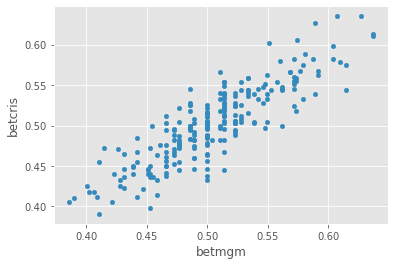

In [46]:
newrecs.plot(x='betmgm', y='betcris', kind='scatter')

## EV Calc one book

In [73]:
crisdf = (test_df
 .query("book.str.contains('draftkings|betmgm')")
 .query("matchup_id.duplicated(keep=False)")
 .sort_values(['matchup_id','book'])
 .reset_index(drop=True)
)

In [74]:
crisdf

,matchup_id,year,book,p1_open,p1_close,p1_prob_novig,p2_open,p2_close,p2_prob_novig,p1_outcome
0,2023-2023-10-11049-24342-R4 Match-Up,2023,betmgm,1.91,1.87,0.510969,1.91,1.95,0.489031,0.0
1,2023-2023-10-11049-24342-R4 Match-Up,2023,draftkings,1.87,1.83,0.523224,1.95,2.00,0.476776,0.0
2,2023-2023-10-11276-12477-R4 Match-Up,2023,betmgm,1.55,1.44,0.668651,2.50,2.80,0.331349,0.0
3,2023-2023-10-11276-12477-R4 Match-Up,2023,draftkings,1.43,1.43,0.680159,2.95,2.95,0.319841,0.0
4,2023-2023-10-12423-21756-R4 Match-Up,2023,betmgm,1.74,1.75,0.547619,2.10,2.10,0.452381,0.0
...,...,...,...,...,...,...,...,...,...,...
1195,2023-2023-9-7655-12294-R3 Match-Up,2023,draftkings,2.30,2.30,0.402926,1.59,1.59,0.597074,1.0
1196,2023-2023-9-9586-14796-R3 Match-Up,2023,betmgm,2.65,2.65,0.355346,1.50,1.50,0.644654,0.0
1197,2023-2023-9-9586-14796-R3 Match-Up,2023,draftkings,2.70,2.70,0.340358,1.45,1.45,0.659642,0.0
1198,2023-2023-9-9771-26651-R4 Match-Up,2023,betmgm,1.87,1.85,0.513860,1.95,1.95,0.486140,1.0


In [91]:
def dec_to_us(decimal):
    if decimal < 2:
        return round(-100/(decimal - 1))
    else:
        return round(100*(decimal - 1))
        

In [95]:
dec_to_us(1.909)

-110

In [ ]:
()

In [101]:
evdf = (crisdf
 .query("book == 'draftkings'")
 .drop(columns=['p1_open','p2_open','p1_close','p2_close'], axis=1)
 .merge(crisdf.query("book == 'betmgm'")[['matchup_id','p1_open','p2_open']])
 .assign(
     p1us = crisdf.p1_close.apply(dec_to_us),
     p2us = crisdf.p2_close.apply(dec_to_us),
     ifwin = ,
     iflose = ,
     p1ev = crisdf['p1_prob_novig']*crisdf['p1_open'] - 1,
     p2ev = crisdf['p2_prob_novig']*crisdf['p2_open'] - 1)
)

In [102]:
evdf.sort_values(['p2ev'], ascending=False)

,matchup_id,year,book,p1_prob_novig,p2_prob_novig,p1_outcome,p1_open,p2_open,p1us,p2us,p1ev,p2ev
596,2023-2023-9-6986-19195-R4 Match-Up,2023,draftkings,0.260312,0.739688,0.0,2.80,1.45,110,-133,-0.208333,0.150000
443,2023-2023-475-15473-24481-R4 Match-Up,2023,draftkings,0.563300,0.436700,0.0,1.83,2.00,-169,130,-0.134243,0.087900
265,2023-2023-26-13965-19195-R3 Match-Up,2023,draftkings,0.286199,0.713801,0.0,2.65,1.48,165,-200,-0.218239,0.063679
398,2023-2023-33-5716-20706-R4 Match-Up,2023,draftkings,0.517380,0.482620,1.0,1.90,1.90,-175,135,-0.091442,0.044881
389,2023-2023-33-17780-20519-R3 Match-Up,2023,draftkings,0.544391,0.455609,1.0,1.74,2.10,-179,140,-0.093974,0.027724
...,...,...,...,...,...,...,...,...,...,...,...,...
218,2023-2023-21-7899-25569-R4 Match-Up,2023,draftkings,0.445698,0.554302,0.0,2.00,1.80,-156,130,0.039852,-0.133722
475,2023-2023-480-17538-17543-R4 Match-Up,2023,draftkings,0.624434,0.375566,0.0,1.48,2.65,-385,280,-0.012832,-0.154887
423,2023-2023-34-17488-19895-R4 Match-Up,2023,draftkings,0.406832,0.593168,0.0,2.25,1.66,-500,350,-0.025278,-0.163889
2,2023-2023-10-12423-21756-R4 Match-Up,2023,draftkings,0.544391,0.455609,0.0,1.74,2.10,-227,180,0.036409,-0.171627


In [ ]:
Ploss = 1 - Pwin
    Mwin = payout(odds)
    return round((Pwin * Mwin) - (1 - Pwin * 100), 2)